In [1]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 3.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
import re
import nltk.corpus
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords, words
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import scale, MinMaxScaler
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Preprocessing + Feature extraction

In [3]:
test_label = pd.read_csv("test_labels.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
# Merging test and train to form one huge dataset
test_data = pd.merge(test, test_label)
dataset = pd.concat([test_data, train])
dataset.drop(columns=['id'], inplace=True)
dataset.drop_duplicates(inplace=True, ignore_index=True)
dataset.drop(dataset.index[dataset['toxic'] == -1], inplace = True)
dataset.reset_index(inplace = True)
# Text cleaning
#converting to lower case
dataset['comment_text_cleaned'] = dataset['comment_text'].str.lower()
#removing special characters
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", str(elem)))
#removing numbers
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda elem: re.sub(r"\d+", "", str(elem)))
# Removing stop words
stop = stopwords.words('english')
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#Tokenizing
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: word_tokenize(x))
#Lemmitization
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: word_lemmatizer(x))
# Splitting into train test sets
X = dataset.drop(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
y = dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()

X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X,y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val,y_test_and_val, train_size=0.5)
train_tokens = pd.Series(X_train['comment_text_cleaned']).values
w2v_model = Word2Vec(train_tokens, size= 200)
def buildWordVector(tokens, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0.
  for word in tokens:
    try:
      vec += w2v_model[word].reshape((1, size))
      count += 1.
    except KeyError:
      continue
  if count != 0:
    vec /= count
  return vec

train_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in train_tokens])
train_vecs_w2v = scale(train_vecs_w2v)

val_tokens = pd.Series(X_val['comment_text_cleaned']).values
val_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in val_tokens])
val_vecs_w2v = scale(val_vecs_w2v)

def evaluation_metric(model_name, feature_extraction, y_true, y_pred):
  print('Model:', model_name)
  print('Feature extraction method:', feature_extraction)
  recall= recall_score(y_true, y_pred, average='micro')
  prec = precision_score(y_true, y_pred, average='micro')
  final_score = recall*0.6 + prec*0.4
  print('Precision: ', prec)
  print('Recall: ', recall)
  print('Final score of the model: ', final_score)
  return final_score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
classifier = ClassifierChain(GaussianNB())
classifier.fit(train_vecs_w2v, y_train)
predictions = classifier.predict(val_vecs_w2v)
evaluation_metric('Naive Bayes with Classifier Chain', 'Word2Vec', y_val, predictions)

# KFolds

In [ ]:
# Applying kfold on train + validation set
classifier = ClassifierChain(GaussianNB())

result = pd.concat([train_vecs_w2v, val_vecs_w2v])
kf = KFold(n_splits = 5, random_state = 1, shuffle = True)
for train_index, val_index in kf.split(result):
  X_train_n, X_val_n = X.iloc[train_index], X.iloc[val_index]
  y_train_n, y_val_n = y.iloc[train_index], y.iloc[val_index]
  classifier = ClassifierChain(GaussianNB())
  classifier.fit(X_train_n, y_train_n)
  predictions = classifier.predict(X_val_n)
  print('The accuracy of the model is:', evaluation_metric('Naive Bayes with Classifier Chain', 'Word2Vec', y_val, predictions))

# Learning curves

In [23]:
import tensorflow as tf
model = Sequential()
model.add(Dense(160, input_dim = train_vecs_w2v.shape[1], activation='sigmoid', kernel_initializer='he_uniform'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])
history = model.fit(train_vecs_w2v, y_train, epochs=50, verbose=0, validation_data=(val_vecs_w2v, y_val)) #epochs=100

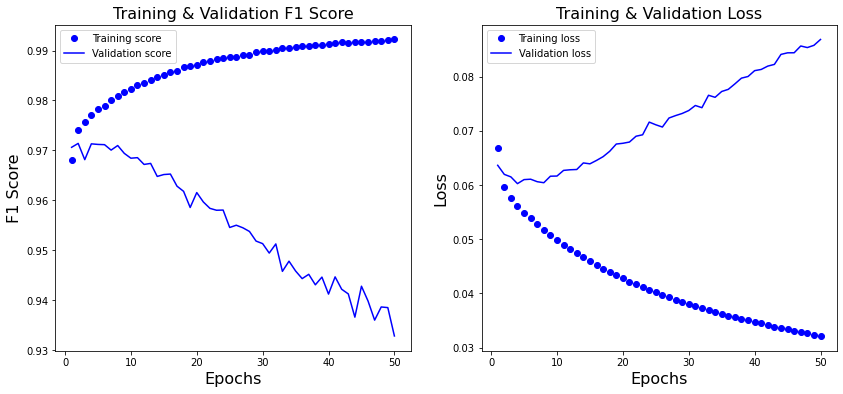

In [26]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['auc_1']
val_accuracy = history_dict['val_auc_1']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training score')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation score')
ax[0].set_title('Training & Validation F1 Score', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('F1 Score', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [25]:
print(history_dict.keys())

dict_keys(['loss', 'auc_1', 'val_loss', 'val_auc_1'])


In [ ]:
sizes, training_scores, testing_scores = learning_curve(model, train_vecs_w2v, y_train, cv=10, scoring='f1_micro', train_sizes=np.linspace(0.01, 1.0, 50))